In [62]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras as kr
from tensorflow.python.keras import layers
import keras.backend as KTF
from tensorflow.python.keras import Sequential

In [63]:
# 进行配置，使用60%的GPU， 这是为了保护GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction= 0.6
session  = tf.compat.v1.Session(config = config)
# 设置Session
KTF.set_session(session)

In [64]:
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [65]:
tf.test.is_built_with_cuda()
tf.test.is_built_with_gpu_support()
tf.config.list_physical_devices('GPU')

[]

In [66]:
import pathlib
data_dir= "C:\\Users\\natlq\\Downloads\\wavespring\\test"
data_dir = pathlib.Path(data_dir)

In [67]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15


In [68]:
print(list(data_dir.glob('*/*.jpg')))

[WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/230632.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/230800.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/234252.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/234356.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/234452.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/234627.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/234751.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/234914.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/235032.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/235207.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/235332.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/235442.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/235605.jpg'), WindowsPath('C:/Users/natlq/Downloads/wavespring/test/OK/235756.jpg'), Windo

In [22]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

IndexError: list index out of range

In [ ]:
PIL.Image.open(str(roses[3]))

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [ ]:
PIL.Image.open(str(tulips[1]))

In [69]:
batch_size = 32
img_height = 1028
img_width =1024

In [70]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 25 files belonging to 2 classes.
Using 20 files for training.


In [71]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 25 files belonging to 2 classes.
Using 5 files for validation.


In [72]:
class_names = train_ds.class_names
print(class_names)

['NG', 'OK']


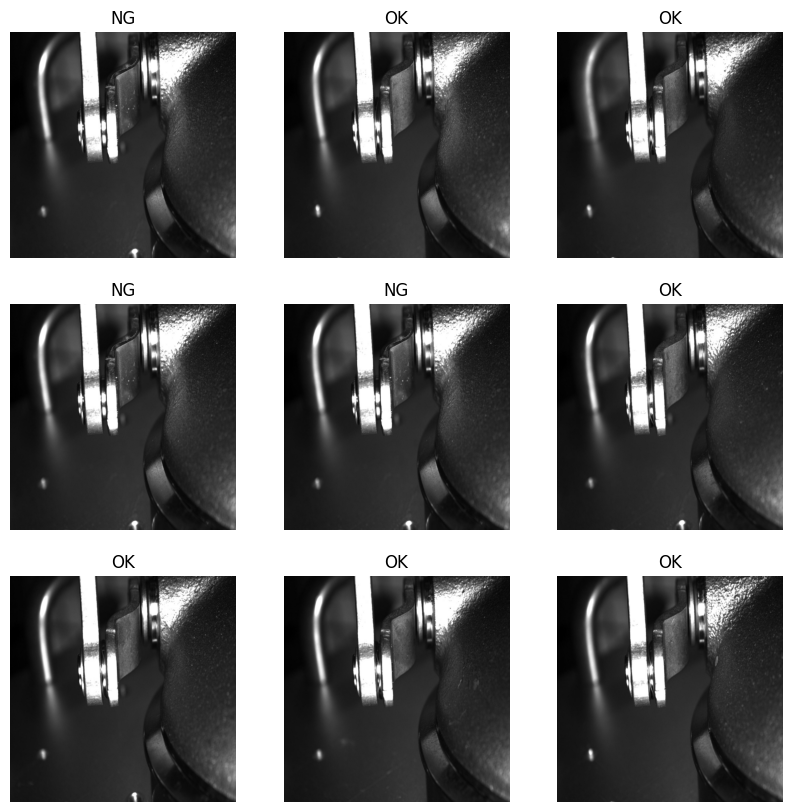

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [74]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(20, 1028, 1024, 3)
(20,)


In [75]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds  = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [76]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [77]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [78]:
num_classes = len(class_names)

model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [79]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

 4/59 [=>............................] - ETA: 7:30 - loss: 6.4116 - accuracy: 0.4766

KeyboardInterrupt: 

In [18]:
# model.fit()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 1024, 1024, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 1024, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0

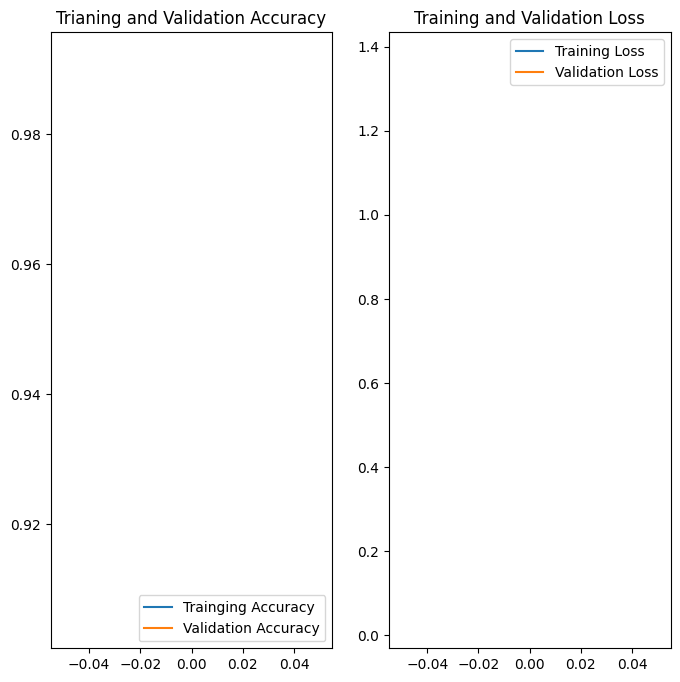

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = "Trainging Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Trianing and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
data_augmentation = Sequential(
    [
    # tf.keras.layers.RandomFlip("horizontal",
                            #    input_shape=(img_height,
                                            # img_width,
                                            # 3)),
    # tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.7, -0.7))
    ]
)

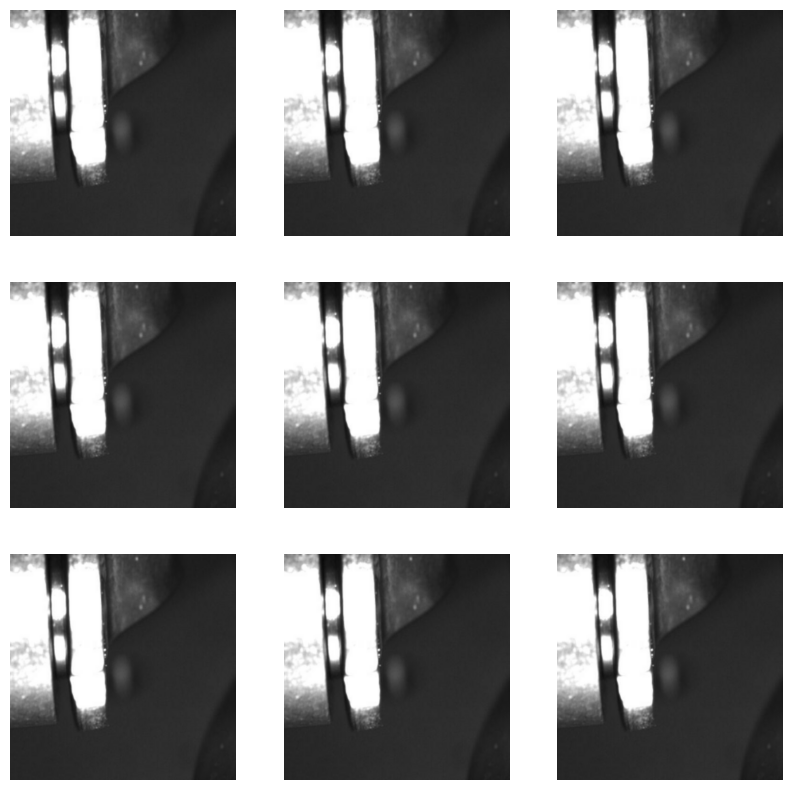

In [81]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmentation_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmentation_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [83]:
model = Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
epochs = 1 # 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

1/1 [==============================] - 6s 6s/step - loss: 0.6982 - accuracy: 0.4500 - val_loss: 57.3147 - val_accuracy: 0.6000


In [86]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 1028, 1024, 3)     0         
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 1028, 1024, 3)     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1028, 1024, 16)    448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 514, 512, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 514, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 257, 256, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 257, 256, 64)     

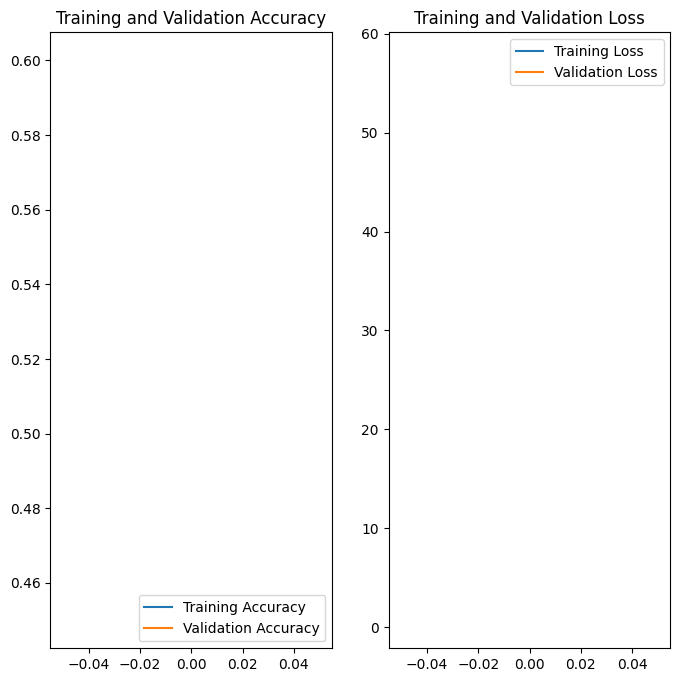

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [91]:
sunflower_path = "C:\\Users\\natlq\\Downloads\\predict\\NG\\2342543.png"
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
image_array = np.expand_dims(img_array, axis=0)
print(img_array.size)
print(image_array.size)

predictions = model.predict(image_array)
score = tf.nn.softmax(predictions[0])

print(
    "This iamge most likely belongs to {} with a {:.2f} precent confidence."
    .format(class_names[np.argmax(score)], 100* np.max(score))
)

3158016
3158016
This iamge most likely belongs to OK with a 100.00 precent confidence.


In [39]:
predict_path_ok = "C:\\Users\\natlq\\Downloads\\predict\\OK"
predict_path_ng = "C:\\Users\\natlq\\Downloads\\predict\\NG"
OK_DIR= pathlib.Path(predict_path_ok)
NG_DIR= pathlib.Path(predict_path_ng)
print(len(list(OK_DIR.glob('*.jpg'))))
for i in range(len(list(OK_DIR.glob('*.jpg')))):
    sunflower_path = list(OK_DIR.glob('*.jpg'))[i]
    img = tf.keras.utils.load_img(
        sunflower_path, target_size=(img_height, img_width)
        )
    img_array = tf.keras.utils.img_to_array(img)
    image_array = np.expand_dims(img_array, axis=0)
    print(img_array.size)
    print(image_array.size)
    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This iamge most likely belongs to {} with a {:.2f} precent confidence."
        .format(class_names[np.argmax(score)], 100* np.max(score))
        )
print(len(list(NG_DIR.glob('*.jpg'))))
for i in range(len(list(NG_DIR.glob('*.jpg')))):
    sunflower_path = list(NG_DIR.glob('*.jpg'))[i]
    img = tf.keras.utils.load_img(
        sunflower_path, target_size=(img_height, img_width)
        )
    img_array = tf.keras.utils.img_to_array(img)
    image_array = np.expand_dims(img_array, axis=0)
    print(img_array.size)
    print(image_array.size)
    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This iamge most likely belongs to {} with a {:.2f} precent confidence."
        .format(class_names[np.argmax(score)], 100* np.max(score))
        )


22
3145728
3145728
This iamge most likely belongs to NG with a 99.04 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.15 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 98.50 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.13 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.44 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.12 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.51 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.13 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 98.88 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.13 precent confidence.
3145728
3145728
This iamge most likely belongs to NG with a 99.28 precent confidence.
3145728
3145728
This iamge most likely belongs to N

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite'
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input = image_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100* np.max(score_lite))
)

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))